## LightGBM

- (XGBoost 대비) 장점
  - 더 빠른 학습과 예측 수행 시간
  - 더 작은 메모리 사용량
  - 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

- 단점
  - 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움 (일반적으로 10000건 이하의 데이터 세트 정도)

LightGBM은 일반 GBM 계열의 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level Wise) 방식이 아닌 **리프 중심 트리 분할(Leaf Wise)** 방식을 사용
- 트리의 균형을 맞추지 않고, 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다. 하지만 이렇게 최대 손실값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있다는 것이 LightGBM의 구현 사상이다.

#### LightGBM 하이퍼 파라미터

주요 파라미터
- num_iterations: 반복 수행하려는 트리의 개수를 지정한다.
- learning_rate: 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값.
- max_depth: 트리 기반 알고리즘의 max_depth와 같다.
- min_data_in_leaf: 결정 트리의 min_samples_leaf와 같다.
- num_leaves: 하나의 트리가 가질 수 있는 최대 리프 개수이다.
- boosting: 부스팅의 트리를 생성하는 알고리즘을 기술한다.
- bagging_fraction: 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율을 지정한다.
- feature_fraction: 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율이다.
- lambda_l2: L2 regulation 제어를 위한 값
- lambda_l1: L1 regulation 제어를 위한 값

Learning Task 파라미터
- objective : 최솟값을 가져야 할 손실함수를 정의한다.

#### 하이퍼 파라미터 튜닝 방안

- num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미커이다. 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커진다.

- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀐다. 과적합을 개선하기 위한 중요한 파라미터이다. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.

- max_depth는 명시적으로 깊이의 크기를 제한한다. num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는 데 사용한다.

In [2]:
import lightgbm

print(lightgbm.__version__)

3.3.5


In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


- 조기 중단으로 111번 반복까지만 수행하고 학습을 종료

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

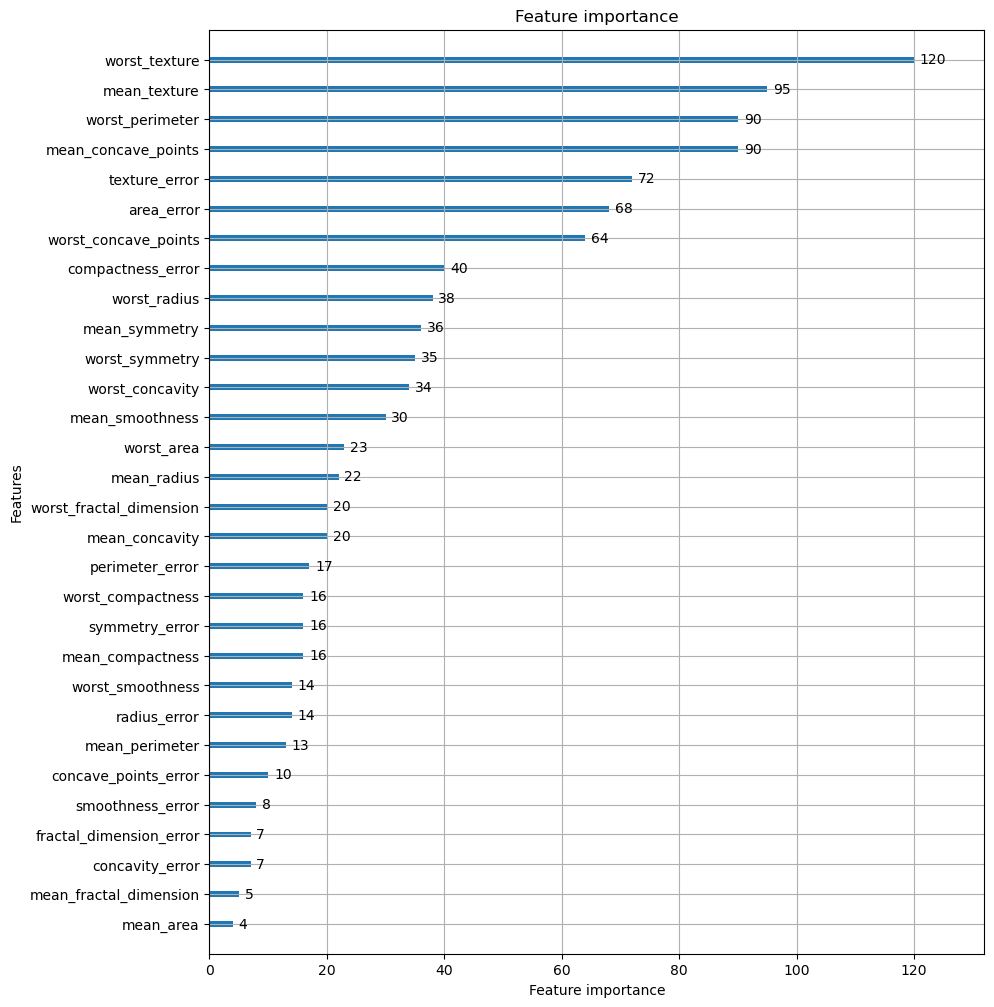

In [6]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

## 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

- Grid Search 방식의 주요 단점 : 튜닝해야 할 하이퍼 파라미터 개수가 많은 경우 최적화 수행 시간이 오래 걸림 -> 실무의 대용량 학습 데이터에 베이지안 최적화 기법 적용

### 베이지안 최적화 개요

- 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
- 베이지안 최적화는 베이지안 확률에 기반을 두고 있는 최적화 기법으로 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적함수 모델을 만을어 낸다.
- 베이지안 최적화를 구성하는 두 가지 중요 요소 : 대체 모델(Surrogate Model), 획득 함수(Acquisition Function)

### 베이지안 최적화 단계

- Step 1: 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링하고 성능 결과를 관측.


- Step 2: 관측된 값을 기반으로 대체 모델은 최적 함수를 추정. 최적 관측값은 y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터.


- Step 3: 추정된 최적 함수를 기반으로 획득 함수(Acquisition Function)는 다음으로 관측할 하이퍼 파라미터 값을 계산. 획득 함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아서 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달.


- Step 4: 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델은 갱신되어 다시 최적 함수를 예측 추정.

### HyperOpt 사용하기

1. 입력 변수명과 입력값의 검색 공간(Search Space) 설정
2. 목적 함수(Objective Function) 설정
3. 목적 함수의 반환 최솟값을 가지는 최적 입력값을 유추

In [7]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정.
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

입력값의 검색 공간을 제공하는 대표적인 함수

- hp.quniform(label, low, high, q): label로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 q의 간격을 가지고 설정
- hp.uniform(label, low, high): 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정
- hp.randint(label, upper); 0부터 최댓값 upper까지 random한 정숫값으로 검색 공간 설정
- hp.loguniform(label, low, high): exp(uniform(low,high)값을 반환하며, log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정
- hp.choice(label,options): 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우 설정

In [8]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

fmin()함수의 주요인자

- fn: 위에서 생상한 objective_func와 같은 목적 함수입니다.
- space: 위에서 생성한 search_space와 같은 검색 공간 딕셔너리입니다.
- algo: 베이지안 최적화 적용 알고리즘
- max_evals: 최적 입력값을 찾기 위한 입력값 시도 횟수입니다.
- trials: 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장하는 데 사용됩니다.
- rstate: fmin()을 수행할 때마다 동일한 결괏값을 가질 수 있도록 설정하는 랜덤 시드(seed) 값입니다.

In [9]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████████████████| 5/5 [00:00<00:00, 310.58trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [10]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|████████████████████| 20/20 [00:00<00:00, 867.68trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


- 20회의 반복 시 완벽한 정답인 x=0은 도출하지 못했지만, 그리드 서치는 21*31-651회의 반복이 필요한 반면 베이지안 최적화는 20회의 반복만으로 일정 수준의 최적값을 근사해 낼 수 있음을 확인

In [11]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임. 
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [12]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [13]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

In [14]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [15]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [16]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [17]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [18]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|████████| 50/50 [00:06<00:00,  8.33trial/s, best loss: -0.9692401533635412]
best: {'colsample_bytree': 0.548301545497125, 'learning_rate': 0.1840281762576621, 'max_depth': 18.0, 'min_child_weight': 2.0}


In [19]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.5483, learning_rate:0.18403, max_depth:18, min_child_weight:2


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [21]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.54472	validation_1-logloss:0.58675
[1]	validation_0-logloss:0.44155	validation_1-logloss:0.52577
[2]	validation_0-logloss:0.36542	validation_1-logloss:0.48906
[3]	validation_0-logloss:0.30756	validation_1-logloss:0.45704
[4]	validation_0-logloss:0.26142	validation_1-logloss:0.41671
[5]	validation_0-logloss:0.22616	validation_1-logloss:0.39605
[6]	validation_0-logloss:0.19465	validation_1-logloss:0.37095
[7]	validation_0-logloss:0.16951	validation_1-logloss:0.36066
[8]	validation_0-logloss:0.14718	validation_1-logloss:0.34686
[9]	validation_0-logloss:0.13006	validation_1-logloss:0.33716
[10]	validation_0-logloss:0.11635	validation_1-logloss:0.32332
[11]	validation_0-logloss:0.10455	validation_1-logloss:0.32073
[12]	validation_0-logloss:0.09388	validation_1-logloss:0.31916
[13]	validation_0-logloss:0.08434	validation_1-logloss:0.30988
[14]	validation_0-logloss:0.07702	validation_1-logloss:0.30469
[15]	validation_0-logloss:0.07144	validation_1-logloss:0.30293
[1

[130]	validation_0-logloss:0.01444	validation_1-logloss:0.25694
[131]	validation_0-logloss:0.01440	validation_1-logloss:0.25884
[132]	validation_0-logloss:0.01436	validation_1-logloss:0.25713
[133]	validation_0-logloss:0.01432	validation_1-logloss:0.25716
[134]	validation_0-logloss:0.01429	validation_1-logloss:0.25689
[135]	validation_0-logloss:0.01425	validation_1-logloss:0.25694
[136]	validation_0-logloss:0.01421	validation_1-logloss:0.25750
[137]	validation_0-logloss:0.01417	validation_1-logloss:0.25745
[138]	validation_0-logloss:0.01413	validation_1-logloss:0.25686
[139]	validation_0-logloss:0.01410	validation_1-logloss:0.25660
[140]	validation_0-logloss:0.01406	validation_1-logloss:0.25843
[141]	validation_0-logloss:0.01403	validation_1-logloss:0.25847
[142]	validation_0-logloss:0.01400	validation_1-logloss:0.25844
[143]	validation_0-logloss:0.01396	validation_1-logloss:0.25898
[144]	validation_0-logloss:0.01393	validation_1-logloss:0.25828
[145]	validation_0-logloss:0.01390	valid

## 분류 실습 - 캐글 산탄데르 고객 만족 예측

### 데이터 전처리

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [10]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.83092	validation_1-auc:0.80941
[2]	validation_0-auc:0.83207	validation_1-auc:0.80903
[3]	validation_0-auc:0.83288	validation_1-auc:0.80889
[4]	validation_0-auc:0.83414	validation_1-auc:0.80924
[5]	validation_0-auc:0.83524	validation_1-auc:0.80907
[6]	validation_0-auc:0.83568	validation_1-auc:0.81005
[7]	validation_0-auc:0.83741	validation_1-auc:0.81088
[8]	validation_0-auc:0.83896	validation_1-auc:0.81305
[9]	validation_0-auc:0.83949	validation_1-auc:0.81363
[10]	validation_0-auc:0.83908	validation_1-auc:0.81277
[11]	validation_0-auc:0.83913	validation_1-auc:0.81260
[12]	validation_0-auc:0.84009	validation_1-auc:0.81325
[13]	validation_0-auc:0.84081	validation_1-auc:0.81329
[14]	validation_0-auc:0.84196	validation_1-auc:0.81380
[15]	validation_0-auc:0.84394	validation_1-auc:0.81540
[16]	validation_0-auc:0.84414	validation_1-auc:0.81573
[17]	validation_0-auc:0.84437	validation_1-auc:0.81577
[18]	validation_0-au

[149]	validation_0-auc:0.90451	validation_1-auc:0.83346
[150]	validation_0-auc:0.90459	validation_1-auc:0.83343
[151]	validation_0-auc:0.90462	validation_1-auc:0.83344
[152]	validation_0-auc:0.90476	validation_1-auc:0.83342
[153]	validation_0-auc:0.90494	validation_1-auc:0.83339
[154]	validation_0-auc:0.90507	validation_1-auc:0.83336
[155]	validation_0-auc:0.90512	validation_1-auc:0.83334
[156]	validation_0-auc:0.90518	validation_1-auc:0.83331
[157]	validation_0-auc:0.90524	validation_1-auc:0.83339
[158]	validation_0-auc:0.90543	validation_1-auc:0.83330
[159]	validation_0-auc:0.90553	validation_1-auc:0.83331
[160]	validation_0-auc:0.90567	validation_1-auc:0.83342
[161]	validation_0-auc:0.90586	validation_1-auc:0.83339
[162]	validation_0-auc:0.90592	validation_1-auc:0.83340
[163]	validation_0-auc:0.90594	validation_1-auc:0.83340
[164]	validation_0-auc:0.90622	validation_1-auc:0.83337
[165]	validation_0-auc:0.90634	validation_1-auc:0.83333
[166]	validation_0-auc:0.90645	validation_1-auc:

In [12]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 100,
                            max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            colsample_bytree = search_space['colsample_bytree'],
                            learning_rate = search_space['learning_rate']
                            )
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits = 3)
    
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

In [ ]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5)   
                       )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

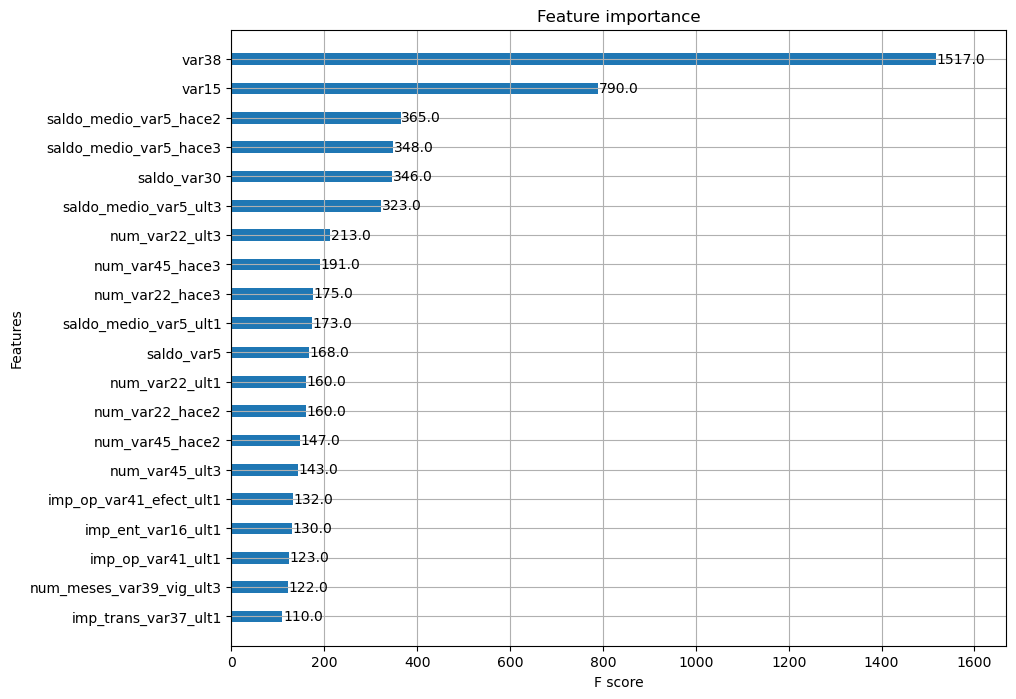

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [17]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

[75]	training's auc: 0.928639	training's binary_logloss: 0.104167	valid_1's auc: 0.83094	valid_1's binary_logloss: 0.135819
[76]	training's auc: 0.928812	training's binary_logloss: 0.104032	valid_1's auc: 0.831078	valid_1's binary_logloss: 0.135819
[77]	training's auc: 0.929094	training's binary_logloss: 0.103841	valid_1's auc: 0.831173	valid_1's binary_logloss: 0.135831
[78]	training's auc: 0.929304	training's binary_logloss: 0.103661	valid_1's auc: 0.831108	valid_1's binary_logloss: 0.135854
[79]	training's auc: 0.929558	training's binary_logloss: 0.103444	valid_1's auc: 0.830932	valid_1's binary_logloss: 0.135942
[80]	training's auc: 0.930062	training's binary_logloss: 0.103185	valid_1's auc: 0.831212	valid_1's binary_logloss: 0.135846
[81]	training's auc: 0.93021	training's binary_logloss: 0.103035	valid_1's auc: 0.831221	valid_1's binary_logloss: 0.13587
[82]	training's auc: 0.930873	training's binary_logloss: 0.102757	valid_1's auc: 0.831112	valid_1's binary_logloss: 0.135917
[83

In [18]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                     }

In [19]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators=100,
                              num_leaves=int(search_space['num_leaves']),
                              max_depth=int(search_space['max_depth']),
                              min_child_samples=int(search_space['min_child_samples']),
                              subsample=search_space['subsample'],
                              learning_rate=search_space['learning_rate']
                              )
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf=KFold(n_splits=3)
    
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import KFold

trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
            space=lgbm_search_space,
            algo=tpe.suggest,
            max_evals=50,     # 최대 반복 횟수를 지정
            trials=trials,
            rstate=np.random.default_rng(seed=30)
            )

print('best:', best)

In [ ]:
# n_estimators는 500 증가 후 최적으로 찾은 파라미터를 기반으로 학습과 예측 수행
lgbm_clf = LGBMClassifier(n_estimators=500,
                          num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'], 5),
                          learning_rate=round(best['learning_rate'], 5)                                                           
                          )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

## 분류 실습 - 캐글 신용카드 사기 검출

### 언더 샘플링과 오버 샘플링의 이해

- 레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이는 이상 레이블을 가진 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생

**언더 샘플링**

- **많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식**. 즉 정상 레이블을 가진 데이터가 10,000건, 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여 버리는 방식.
- 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여버린 상태에서 학습을 수행하면 **과도하게 정상 레이블로 학습/예측하는 부작용을 개선**할 수 있지만, **너무 많은 정상 레이블 데이터를 감소시켜서 정상 레이블의 경우 제대로 된 학습을 수행할 수 없는 문제가 발생할 수도** 있으므로 유의해야 함.

**오버 샘플링**

- **데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법**. 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식. 
- 대표적으로 **SMOTE(Synthetic Minority Over-sampling Technique)** 방법이 있음. SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식.

### 데이터 일차 가공 및 모델 학습/예측/평가

In [27]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [28]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [29]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [30]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [32]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8529, 재현율: 0.5878,    F1: 0.6960, AUC:0.9576


In [33]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [34]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


### 데이터 분포도 변환 후 모델 학습/예측/평가

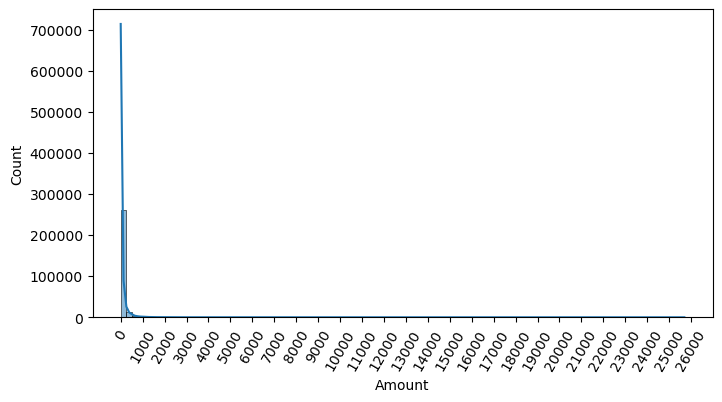

In [35]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [36]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [37]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


In [38]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [39]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


### 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터(Outlier) : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터

이상치 데이터를 찾는 방법
   - IQR : 사분위 값의 편차를 이용하는 기법

<AxesSubplot:>

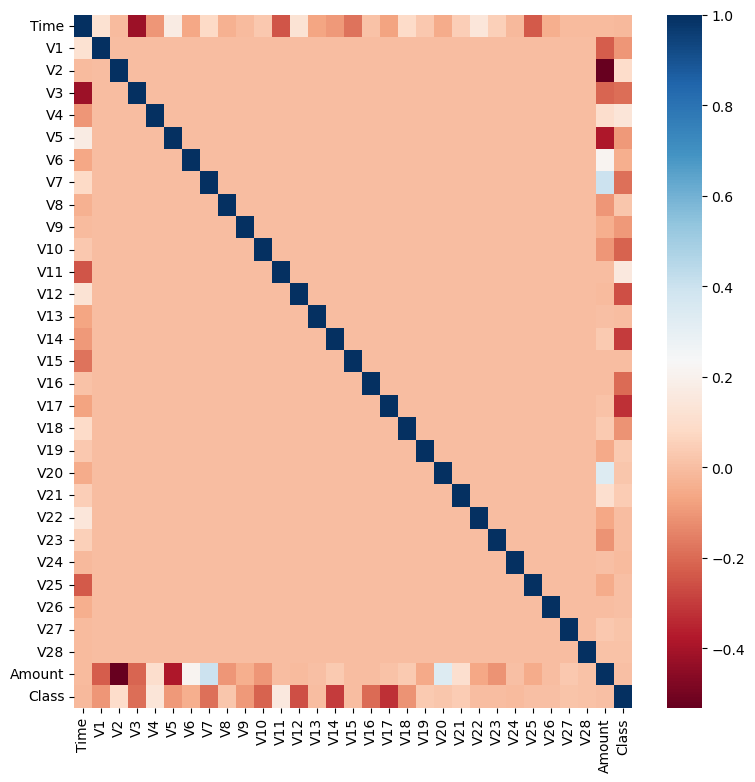

In [40]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [41]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [42]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [43]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [45]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

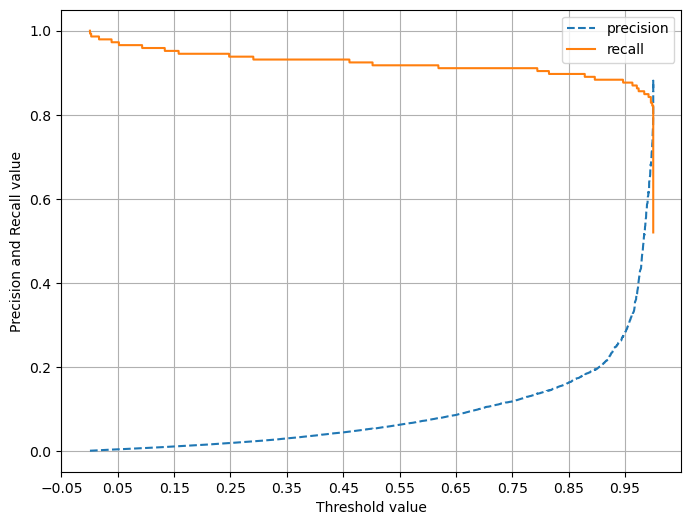

In [47]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)